# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
def crop(df, percent):
    print("Users:", len(df["userId"].unique()))
    print("Movies:", len(df["movieId"].unique()))
    user_counts = df["userId"].value_counts()
    top_users = user_counts[user_counts > user_counts.quantile(percent)]
    df = df[df["userId"].isin(top_users.index)]
    movie_counts = df["movieId"].value_counts()
    top_movies = movie_counts[movie_counts > movie_counts.quantile(percent)]
    df = df[df["movieId"].isin(top_movies.index)]
    print(df.shape)
    print("Users:", len(df["userId"].unique()))
    print("Movies:", len(df["movieId"].unique()))
    return df

Only a small portion of the dataset will be used, using only the 3% top movies that show in the dataset and top 3% of users.

In [3]:
df = pd.read_csv("./rating.csv", sep=",")
df = crop(df, 0.97)

Users: 138493
Movies: 26744
(1761018, 4)
Users: 4144
Movies: 770


In [4]:
df.drop(columns=["timestamp"], inplace=True)

This is the initial dataset, with the User Id, Movie Id and rating. That is, we have the rating given by the user for every movie he rated.

In [5]:
df.head()

,userId,movieId,rating
5400,54,1,4.0
5401,54,2,3.0
5403,54,6,3.0
5404,54,10,4.0
5405,54,11,5.0


In [6]:
df.describe()

,userId,movieId,rating
count,1.761018e+06,1.761018e+06,1.761018e+06
mean,6.869181e+04,4.245153e+03,3.472575e+00
std,3.981728e+04,8.774164e+03,1.001159e+00
min,5.400000e+01,1.000000e+00,5.000000e-01
25%,3.440200e+04,1.129000e+03,3.000000e+00
50%,6.928200e+04,2.100000e+03,3.500000e+00
75%,1.025990e+05,3.793000e+03,4.000000e+00
max,1.384370e+05,7.913200e+04,5.000000e+00


We need to transform this into a matrix, with the Movie Id as column and User Id as index (this can be the other way arround).

In [7]:
matrix = df.pivot(index="userId", columns="movieId", values="rating")
matrix.head()

movieId,1,2,6,10,11,16,17,19,21,22,...,50872,51255,51662,54286,55820,56367,58559,59315,60069,79132
userId,,,,,,,,,,,,,,,,,,,,,
54,4.0,3.0,3.0,4.0,5.0,2.0,2.0,NaN,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,3.0,2.0,1.5,2.0,2.0,3.5,NaN,2.5,3.5,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,5.0,5.0,4.0,4.0,5.0,4.0,4.0,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208,4.0,NaN,NaN,NaN,3.0,1.5,5.0,NaN,4.5,NaN,...,4.0,NaN,3.0,4.5,4.0,4.5,3.5,NaN,3.5,NaN


Next, for each rating, the user average rating will be removed. This is used to try to remove user the user bias. This way, negative ratings will mean the movie is bellow average for the user, and positive ratings will mean the movie is above average for the user

In [8]:
matrix = matrix.apply(lambda row: row - row.mean(), axis=1)
matrix.head()

movieId,1,2,6,10,11,16,17,19,21,22,...,50872,51255,51662,54286,55820,56367,58559,59315,60069,79132
userId,,,,,,,,,,,,,,,,,,,,,
54,0.289617,-0.710383,-0.710383,0.289617,1.289617,-1.710383,-1.710383,NaN,-1.710383,-0.710383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,0.027132,NaN,0.027132,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,0.437630,-0.562370,-1.062370,-0.562370,-0.562370,0.937630,NaN,-0.06237,0.937630,-0.562370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,0.913861,0.913861,-0.086139,-0.086139,0.913861,-0.086139,-0.086139,NaN,-0.086139,-0.086139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208,0.381643,NaN,NaN,NaN,-0.618357,-2.118357,1.381643,NaN,0.881643,NaN,...,0.381643,NaN,-0.618357,0.881643,0.381643,0.881643,-0.118357,NaN,-0.118357,NaN


# User-User Collaborative Filtering 

## Correlation Matrix

This is the most costly operation, to calculate the correlation between every user. In this case, the Pearson Correlation will be used and each user needs to have at least 10 movies in common to have a correlation.

In [9]:
min_common_items = 10
correlation_matrix = matrix.T.corr(method="pearson", min_periods=min_common_items)

In [10]:
correlation_matrix.head()

userId,54,104,116,156,208,298,347,348,359,367,...,138208,138254,138270,138301,138307,138325,138382,138397,138406,138437
userId,,,,,,,,,,,,,,,,,,,,,
54,1.000000,0.114553,0.269821,0.270802,0.172821,0.245273,0.223953,-0.070332,0.234784,0.116278,...,0.156200,0.235974,0.142072,0.173876,0.156422,0.249429,0.248317,0.173988,0.286939,0.190875
104,0.114553,1.000000,0.202915,0.088366,0.304880,-0.099429,0.399825,0.220794,0.183705,0.156648,...,0.112484,0.158680,0.221710,0.224819,0.123594,0.312171,-0.109681,-0.092775,0.242078,0.147310
116,0.269821,0.202915,1.000000,0.175049,0.215795,0.336205,0.345677,0.247348,0.273200,0.501648,...,0.317431,0.357426,0.280276,0.415804,0.145095,0.410156,0.152599,0.264419,0.393933,0.437245
156,0.270802,0.088366,0.175049,1.000000,0.061580,0.256052,0.178544,-0.031419,0.132963,0.332801,...,0.193050,0.259178,0.121299,0.185104,0.074637,0.224374,0.245798,0.272123,0.176687,0.196021
208,0.172821,0.304880,0.215795,0.061580,1.000000,0.005218,0.308763,0.118676,0.250497,0.132541,...,0.260259,0.194055,0.264405,0.142791,0.220351,0.366289,0.012213,-0.117251,0.336622,0.216713


## Recommendation

In [11]:
k = 50

The next 2 functions will serv to calculate the inferred deviation (with the deviation being the `rating - average`, but since the purpose is just to give recomendations, it is not nedded to get the inferred rating, only what is the biggest deviation) of User `i` of Movie `j`. Witch is just the weighted average rating that the `k` most similar users (or most distinct users) to User `i` gave to the Movie `j`, with the correlation being the weight. 

In [12]:
def deviation_per_movie(column, correlations):
    non_na_indices = column.dropna().index
    weighted_ratings = column[non_na_indices] * correlations[non_na_indices]
    sum_correlations = np.abs(correlations[non_na_indices]).sum()
    return weighted_ratings.sum() / sum_correlations if sum_correlations != 0 else 0

In [13]:
def infer_deviations(userId, k=50):
    correlation_user = correlation_matrix.loc[userId].drop(index=[userId]).fillna(value=0)
    similar_users = np.argpartition(np.abs(correlation_user), -k)[-k:]
    matrix_user = matrix.loc[correlation_user.index[similar_users]].iloc[:, matrix.loc[userId].isna().tolist()]
    deviations = matrix_user.apply(lambda x: deviation_per_movie(x, correlations=correlation_user), axis="index")
    return deviations

## Exemple

In this example, we took the User `54` to get the inferred deviation of all the movies this user didn't rate 

In [14]:
inferred_deviations = infer_deviations(54)
inferred_deviations.head()

movieId
19    -1.105431
44    -1.304264
48    -0.796795
62     0.106117
104   -0.255468
dtype: float64

Sorting by the value returned, we get the top movies that we can recommend to this user

In [15]:
inferred_deviations.sort_values(ascending=False)

movieId
1250     1.055932
58559    1.029973
7153     1.026565
912      1.014938
6016     1.010674
           ...   
420     -1.403203
762     -1.430324
1882    -1.435546
4015    -1.480059
355     -1.545190
Length: 404, dtype: float64

# Tests

The algorithm will calculate the infered deviation for all the movies all the users have rated, then using this data it will be possible to extract some metrics.

To achieve this, the infer_deviations function will have to be modified 

In [16]:
def test_infer_deviations(userId, k=50):
    correlation_user = correlation_matrix.loc[userId].drop(index=[userId]).fillna(value=0)
    similar_users = np.argpartition(np.abs(correlation_user), -k)[-k:]
    matrix_user = matrix.loc[correlation_user.index[similar_users]].iloc[:, matrix.loc[userId].notna().tolist()] # Change in this line, .isna() becomes .notna()
    deviations = matrix_user.apply(lambda x: deviation_per_movie(x, correlations=correlation_user), axis="index")
    return deviations

In [17]:
users = matrix.index.tolist()

In [18]:
y_pred = np.array(list())
y_true = np.array(list())
for user in users:
    deviations = np.array(test_infer_deviations(userId=user))
    ratings = np.array(matrix.loc[user][matrix.loc[user].notna()])
    y_pred = np.append(y_pred, deviations)
    y_true = np.append(y_true, ratings)    

In [19]:
mse = np.mean((y_true - y_pred) ** 2)
mae = np.mean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred)**2))


In [20]:
print("MSE: ", round(mse, 3))
print("MAE: ", round(mae, 3))
print("RMSE: ", round(rmse, 3))

MSE:  0.526
MAE:  0.557
RMSE:  0.725


With the average error (MAE) being arround 0.55, a low margin of error is expected from the model. With the error distribution, it is possible to make a confidence interval to the error, assuming the error is approximately a normal distribution

In [21]:
error = y_true - y_pred

To make a error bound for this case, we need to know the distribution of the error

c:\Users\ivanf\miniconda3\envs\collabfiltering\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ivanf\miniconda3\envs\collabfiltering\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

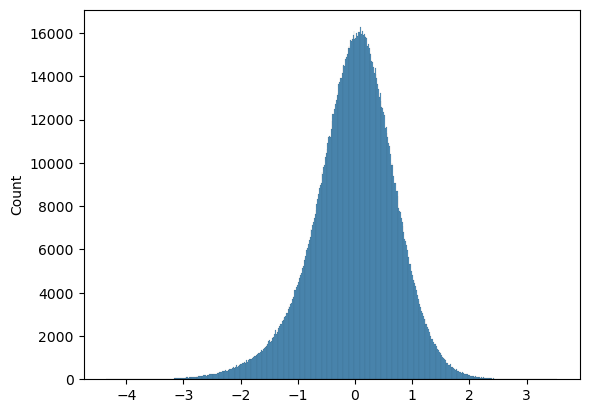

In [24]:
sns.histplot(error)

We can see that the error follows a normal distribution, so...

In [22]:
lower, higher = np.percentile(error, [10,90], method="normal_unbiased")

In [23]:
print(f"Lower bound: {lower}; High bound: {higher}")

Lower bound: -0.93380395246642; High bound: 0.8404133466493446


With the error distribution, in 90% of cases the error will be between -0.93 and 0.84, witch can be used to make sure a recomendation is really a good recomendation for the user.